In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import kagglehub
import joblib
from tqdm import tqdm
from  sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate, train_test_split
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
import swifter
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.sparse import vstack
from sklearn.naive_bayes import BernoulliNB

from sklearn.svm import LinearSVC
import string
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import contractions

import emoji


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
# Download data from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140/data
# path = kagglehub.dataset_download("kazanova/sentiment140")

# print("Path to dataset files:", path)

<!-- <p style="color: lightblue;">Sentiment labeling in the dataset:</p>
<ul>
  <li>0 = negative</li>
  <li>2 = neutral</li>
  <li>4 = positive</li>
</ul> -->
Sentiment labeling in the dataset:
- 0 = negative
- 4 = positive

In [106]:
df = pd.read_csv('train.csv', header=None, names=["sentiment", "ids", "date", "flag", "user", "text"])
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [108]:
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

We then create another dataframe where it only have the columns we will be using :

In [109]:
df_cleaned = df[['sentiment', 'text']]
df_cleaned.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We will map the labels (0 = negative, 1 = positive)

In [110]:
df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)
df_cleaned

C:\Users\dell\AppData\Local\Temp\ipykernel_13924\3272369782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


### Let's check the distribution of sentiments:

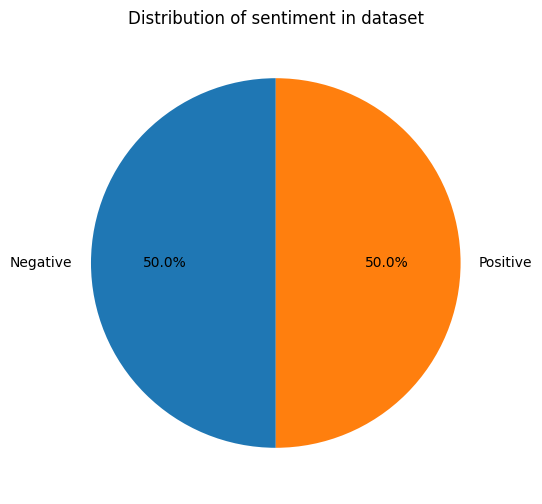

In [111]:

# Pie chart
# Count sentiment values, ensuring no NaNs or invalid entries
sentiment_counts = df_cleaned['sentiment'].value_counts()
labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'})

# Pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of sentiment in dataset')
plt.show()

As we can see there is a balance between positive and negative sentiment.

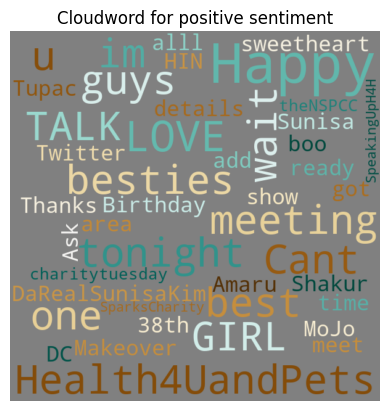

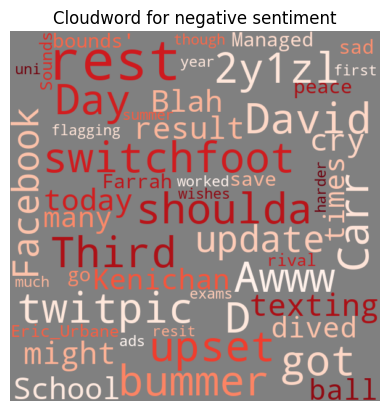

In [112]:
from wordcloud import STOPWORDS
text_positive = str(df_cleaned[df_cleaned['sentiment'] == 1]['text'].values)
text_negative = str(df_cleaned[df_cleaned['sentiment'] == 0]['text'].values)

def plot_word_cloud(text,desc,color) :


    wc = WordCloud(width=600,height=600,background_color="gray", max_words=200, stopwords=STOPWORDS,colormap=color,  max_font_size=90,collocations = False, random_state=42)

    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cloudword for {desc}")
    plt.show()


plot_word_cloud(text_positive, "positive sentiment", "BrBG")
plot_word_cloud(text_negative, "negative sentiment", "Reds")

# Preprocessing

In [113]:
import emoji
class TextPreprocessor:
    def __init__(self):
        # Initialize the word lemmatizer and the emojis dictionary
        self.word_lemmatizer = WordNetLemmatizer()
        self.emojis = {
            ':)': 'smile',
             ':-)': 'smile',
             ';d': 'wink',
             ':-E': 'vampire',
             ':(': 'sad',

            ':-(': 'sad',
             ':-<': 'sad',
             ':P': 'raspberry',
             ':O': 'surprised',

            ':-@': 'shocked',
             ':@': 'shocked',
            ':-$': 'confused',
             ':\\': 'annoyed',

            ':#': 'mute',
             ':X': 'mute',
             ':^)': 'smile',
             ':-&': 'confused',
             '$_$': 'greedy',

            '@@': 'eyeroll',
             ':-!': 'confused',
             ':-D': 'smile',
             ':-0': 'yell',
             'O.o': 'confused',

            '<(-_-)>': 'robot',
             'd[-_-]b': 'dj',
             ":'-)": 'sad smile',
             ';)': 'wink',
             ';D': 'wink',

            ';-)': 'wink',
             'O:-)': 'angel',
            'O*-)': 'angel',
            '(:-D': 'gossip',
             '=^.^=': 'cat',
             ':D':'smile',
        }

    def clean_text(self, text):
        """Cleaning text from unwanted elements"""
        text = text.lower().strip()
        text = contractions.fix(text)
        # Remove URLs
        text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # Remove @username
        text = re.sub(r'@\w+', '', text).strip()
        # Remove email addresses
        text = re.sub(r'[\w\.\-\+]+@([\w\-]+\.)+[\w\-]{2,4}', '', text)
        # Remove quoted text
        text = re.sub(r'["\'].*?["\']', '', text)
        # Remove hashtags
        text = re.sub(r'#(\w+)', r'\1', text)
        # Remove "etc."
        text = re.sub(r'\betc\.?\b', '', text, flags=re.IGNORECASE)
        return text

    def filter_non_english_words(self, text):
        """
        Remove all words that contain non-English characters.
        """
        pattern = r'\b(?:[a-zA-Z]+|[a-zA-Z_]+)\b'
        filtered = re.findall(pattern, text)
        return ' '.join(filtered)

    def reduce_len_text(self, text):
        """Reduce text repetitive letters """
        repeat_regexp = re.compile(r'(.)\1{2,}')
        return repeat_regexp.sub(r'\1', text)

    def lemmatize_text(self, text):
        return ' '.join(self.word_lemmatizer.lemmatize(word) for word in text.split())
    def handle_emojies(self, text):
        """Replace emojis with text"""
        text = emoji.demojize(text, delimiters=(" ", " "))
        for e, meaning in self.emojis.items():
            text = text.replace(e, meaning)
        return text

    def preprocess(self, text):
        """
        Preprocess using all the previous functions
        """
        # features = self.extract_features(text)

        replace_emojie = self.handle_emojies(text)
        cleaned_text = self.clean_text(replace_emojie)
        no_repetition = self.reduce_len_text(cleaned_text)
        lemmatized_text = self.lemmatize_text(no_repetition)
        clean = self.filter_non_english_words(lemmatized_text)
        # clean = self.filter_non_english_words(lemmatized_text)
        return clean

# pre = TextPreprocessor()
# word = "#cool #awesooome #funny #lolllllll jojojojooooooooj eample@gmail.com #haha #hilariouuuusss #funnnnnnnnnn  i'll be there don't miss it  :() ❤❤ "
# pre.preprocess(word)


In [114]:
# import emoji

text = "#cool #awesooome #funny #lolllllll jojojojooooooooj eample@gmail.com #haha #hilariouuuusss #funnnnnnnnnn  i'll be there don't miss it  :() ❤❤ "

text = emoji.demojize(text, delimiters=(" ", " "))

    # Replace emojis with their meanings from self.emojis
# for emoji, meaning in emojis.items():
#     text = text.replace(emoji, meaning)
text

"#cool #awesooome #funny #lolllllll jojojojooooooooj eample@gmail.com #haha #hilariouuuusss #funnnnnnnnnn  i'll be there don't miss it  :()  red_heart  red_heart  "

In [115]:
import swifter
pre = TextPreprocessor()
df_cleaned['cleaned_text'] = df_cleaned['text'].swifter.apply(pre.preprocess)

df_cleaned.head()

Pandas Apply:   0%|          | 0/1600000 [00:00<?, ?it/s]

C:\Users\dell\AppData\Local\Temp\ipykernel_13924\3692106651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_text'] = df_cleaned['text'].swifter.apply(pre.preprocess)


,sentiment,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aw that is a bummer you shoulda got david carr...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many time for the ball managed to save...
3,0,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i am mad why am i...


# TF-IDF

In [116]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2), max_features=30000)
tfidf.fit(df_cleaned.cleaned_text)


TfidfVectorizer(max_features=30000, ngram_range=(1, 2), stop_words='english')

In [117]:

sparse_matrices = []

for i in tqdm(range(0, len(df_cleaned), 10000), desc='Batch processing'):
    batch = df_cleaned.cleaned_text[i:i + 10000]
    tfidf_matrix_batch = tfidf.transform(batch)

    sparse_matrices.append(tfidf_matrix_batch)

final_sparse_matrix = vstack(sparse_matrices)


Batch processing: 100%|██████████| 160/160 [00:39<00:00,  4.06it/s]


In [118]:
# Big dataset: so we use sparse instead of pandas
df_matrix = pd.DataFrame.sparse.from_spmatrix(final_sparse_matrix, columns=tfidf.get_feature_names_out())
df_matrix['label'] = df_cleaned['sentiment']

In [119]:
df_matrix

,__,aa,aah,aahh,aar,aargh,aaron,aaw,aaww,ab,...,zombie,zombies,zomg,zone,zoo,zoo today,zoom,zune,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will calculate the tfidf score mean, we will use it later to only get words with higher score

In [120]:

tfidf_scores = []
batch_size = 10000

tfidf_matrix_sparse = tfidf.transform(df_cleaned['cleaned_text'])

for start in tqdm(range(0, tfidf_matrix_sparse.shape[0], batch_size)):
    end = min(start + batch_size, tfidf_matrix_sparse.shape[0])
    batch = tfidf_matrix_sparse[start:end]

    # Calculez la moyenne des scores TF-IDF pour chaque document dans le batch
    batch_scores = batch.mean(axis=1).A1  # .A1 convertit en tableau numpy 1D
    tfidf_scores.extend(batch_scores)


df_cleaned['tfidf_score'] = tfidf_scores



100%|██████████| 160/160 [00:00<00:00, 365.36it/s]
C:\Users\dell\AppData\Local\Temp\ipykernel_13924\2476991360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tfidf_score'] = tfidf_scores


In [121]:
df_cleaned

,sentiment,text,cleaned_text,tfidf_score
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aw that is a bummer you shoulda got david carr...,0.000095
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,0.000098
2,0,@Kenichan I dived many times for the ball. Man...,i dived many time for the ball managed to save...,0.000080
3,0,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire,0.000070
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i am mad why am i...,0.000046
...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,0.000089
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdb com very cool to hear old walt interviews,0.000078
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,0.000065
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy birthday to my boo of al time tupac amar...,0.000084


The dataset have +1.6m tweets... So we Will have to reduce it to 500 000, based on tf-idf scores and categories


In [122]:
# simples
df_positive_sample = df_cleaned[df_cleaned['sentiment'] == 1].sort_values(by="tfidf_score", ascending= False).head(500000)
df_negative_sample = df_cleaned[df_cleaned['sentiment'] == 0].sort_values(by="tfidf_score", ascending= False).head(500000)

# Combine simples
df_reduced = pd.concat([df_positive_sample, df_negative_sample])
print(f"Reduced dataset size: {len(df_reduced)}")

Reduced dataset size: 1000000


In [123]:
df_reduced

,sentiment,text,cleaned_text,tfidf_score
848777,1,@jaredleto &quot;best band in the world?&quot;...,quot best band in the world quot oh i did not ...,0.000172
1475283,1,Wedding last nightt was crazy fun! I think my ...,wedding last nightt wa crazy fun i think my li...,0.000171
1405683,1,hahah life's pretty good just hope i make mor...,hahah life s pretty good just hope i make more...,0.000170
1272204,1,getting ready for bed... got a long day tomorr...,getting ready for bed got a long day tomorrow ...,0.000169
1310109,1,Just got home from dinner and a movie with a g...,just got home from dinner and a movie with a g...,0.000169
...,...,...,...,...
163518,0,Really Wish i could see dave from @reemerband ...,really wish i could see dave from again missin...,0.000072
562802,0,Hmmm spaghetti on toast - got no cheese though,hm spaghetti on toast got no cheese though,0.000072
474056,0,@Cariad_Cwtch Ow no! Grrrrr! And it was so p...,ow no gr and it wa so pretty too,0.000072
155788,0,"@shayes287 Nope, not yet hopefully when we wa...",nope not yet hopefully when we wake up tomorro...,0.000072


## TF-IDF for the reduced df: df_reduced

In [124]:
tfidf_reduced = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=30000)
matrix_reduced = tfidf_reduced.fit_transform(df_reduced.cleaned_text)


In [125]:
from scipy.sparse import csr_matrix

# Créer une DataFrame sparse
df_matrix_reduced = pd.DataFrame.sparse.from_spmatrix(matrix_reduced, columns=tfidf_reduced.get_feature_names_out())

# Ajouter la colonne des labels
df_matrix_reduced['label'] = df_reduced['sentiment'].values


In [147]:
df_matrix_reduced['label']

0         1
1         1
2         1
3         1
4         1
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: label, Length: 1000000, dtype: int64

In [127]:
df_matrix_reduced[df_matrix_reduced]

Index(['__', 'aa', 'aah', 'aahh', 'aar', 'aargh', 'aaron', 'aaw', 'aaww', 'ab',
       ...
       'zoe', 'zombie', 'zombies', 'zomg', 'zone', 'zoo', 'zoo today', 'zoom',
       'zune', 'zurich'],
      dtype='object', length=30000)

## Testing models

In [149]:
# Features
X = matrix_reduced
# X = df_matrix

# Labels
y = df_matrix_reduced['label']
# y = df_matrix['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (800000, 30000)
Shape of X_test: (200000, 30000)
Shape of y_train: (800000,)
Shape of y_test: (200000,)


In [150]:
def test_model(x=X,  y=y, model_name=None):
    model = model_name
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    if hasattr(model_name, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return model


Trying with the following models:
<!-- - Naive Bayes Classifier -->
<!-- - Support Vector Machine (SVM) -->
- SGDClassifier
- SVC
- BernoulliNB
- XGBOOST
- Logistic Regression
- Random Forest
<!-- - Gradient Boosting Machines (GBM) -->

### SGDClassifier

F1 Score: 0.7561578829820554
Accuracy: 0.75641
Precision: 0.7574812169276914
Recall: 0.75641

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75    100013
           1       0.74      0.79      0.76     99987

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



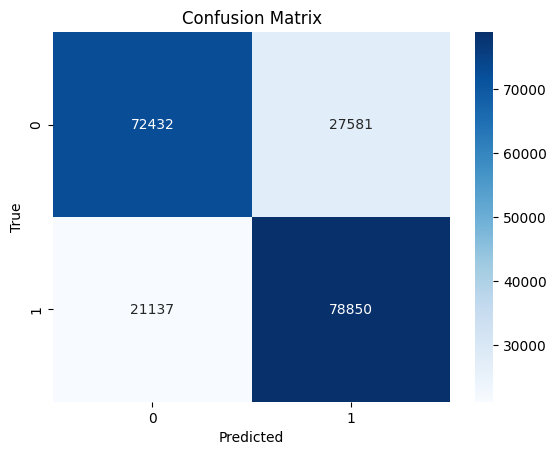

In [151]:
SGDclassifier = test_model(model_name=SGDClassifier())

### Logistique Regression

F1 Score: 0.7764796415010845
Accuracy: 0.776545
Precision: 0.7768723018882505
Recall: 0.776545

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77    100013
           1       0.77      0.79      0.78     99987

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



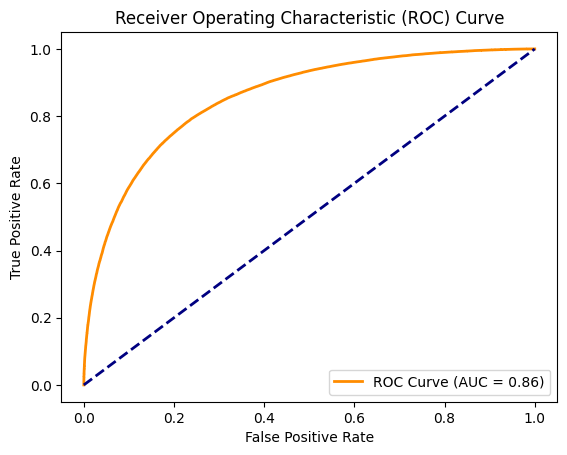

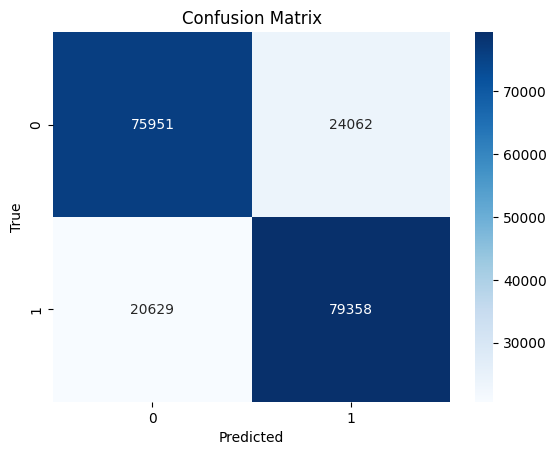

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

LR = test_model(model_name=LogisticRegression(max_iter=1000))


### Random Forest Classifier

In [132]:
# randomforest = test_model(RandomForestClassifier(n_jobs=-1))
# it take too much time (1h20min) and not the most ideal for big dataset

### LinearSVC

F1 Score: 0.773807921303419
Accuracy: 0.773885
Precision: 0.774262566362684
Recall: 0.773885

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77    100013
           1       0.76      0.79      0.78     99987

    accuracy                           0.77    200000
   macro avg       0.77      0.77      0.77    200000
weighted avg       0.77      0.77      0.77    200000



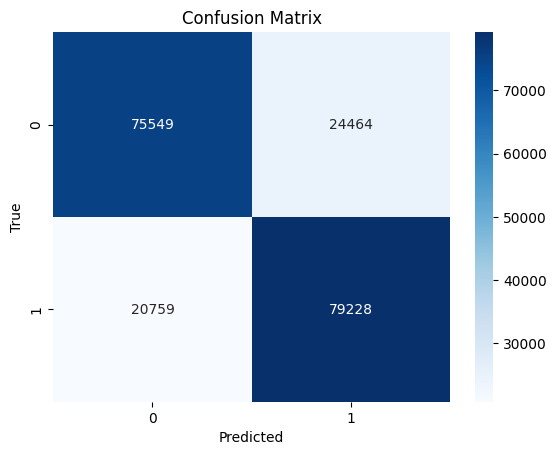

In [133]:
svc = test_model(model_name=LinearSVC())

### BernoulliNB

F1 Score: 0.7602940325769233
Accuracy: 0.760295
Precision: 0.7602996123260218
Recall: 0.760295

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76    100013
           1       0.76      0.76      0.76     99987

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



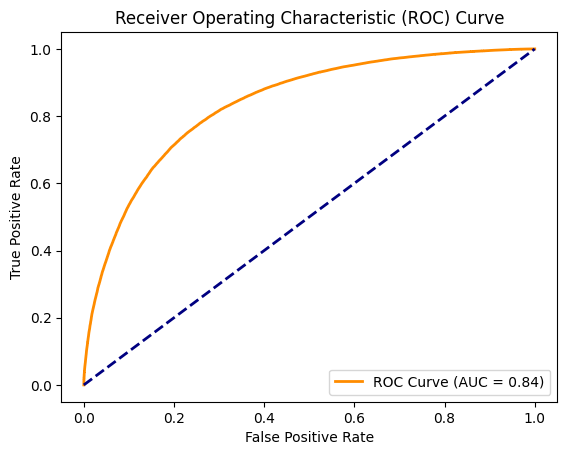

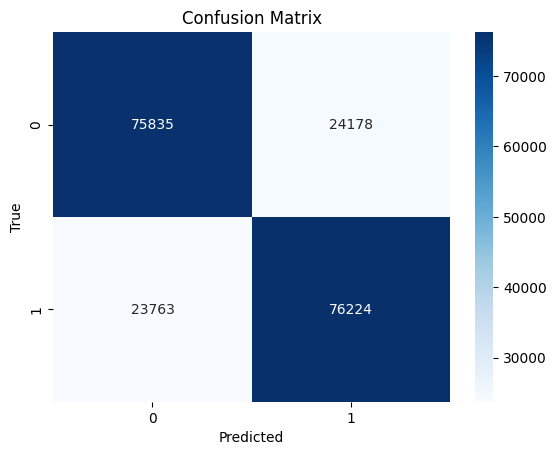

In [134]:
bern = test_model(model_name=BernoulliNB(alpha = 2))

F1 Score: 0.7569568424333586
Accuracy: 0.75696
Precision: 0.756974076514699
Recall: 0.75696

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76    100013
           1       0.76      0.76      0.76     99987

    accuracy                           0.76    200000
   macro avg       0.76      0.76      0.76    200000
weighted avg       0.76      0.76      0.76    200000



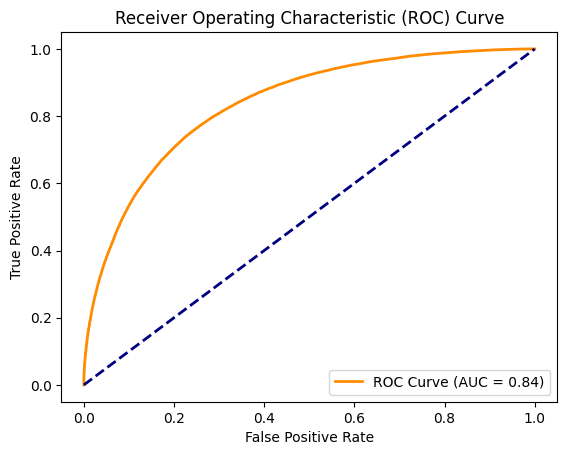

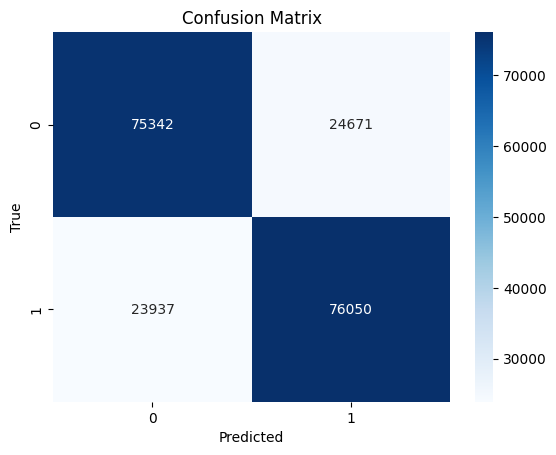

In [135]:
# test with naif bayes
from sklearn.naive_bayes import MultinomialNB

MultinomialnNB = test_model(model_name= MultinomialNB())
# MultinomialnNB.score(X_test, y_test)


### XGBoost Classifier

In [136]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



model = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# test_model(XGBClassifier(tree_method='gpu-hist', predictor="gpu_predictor"))

c:\Users\dell\anaconda3\envs\Myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\dell\anaconda3\envs\Myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\dell\anaconda3\envs\Myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\

F1 Score: 0.7125695858743801
Accuracy: 0.712615
Precision: 0.7127518007263374
Recall: 0.712615


Best one so fars was Logistique regression with  an accuracy of 77%

In [137]:
# Prédire les probabilités des classes
probs = LR.predict_proba(X_test)

# Exemple : probs[:, 0] -> probabilité de négatif, probs[:, 1] -> probabilité de positif
neutral_threshold = 0.1  # Ajustez ce seuil selon vos besoins

# Liste pour stocker les prédictions finales
final_predictions = []

for prob_neg, prob_pos in probs:
    if abs(prob_pos - prob_neg) < neutral_threshold:
        final_predictions.append('neutral')
    elif prob_pos > prob_neg:
        final_predictions.append('positive')
    else:
        final_predictions.append('negative')


len(final_predictions)

200000

Quick test of the model

In [156]:
# Nouveaux textes
new_texts = ["I love this product, it is amazing!",
             "I hate this damn it:",
             "Damn! i love it "]

# Nouveaux textes avec des mots de haine

# Prétraitement
preprocessed_texts = [pre.preprocess(text) for text in new_texts]  # Assurez-vous d'utiliser votre fonction de prétraitement

# Transformation en TF-IDF (utiliser le même tfidf_reduced que pendant l'entraînement)
new_texts_tfidf = tfidf_reduced.transform(preprocessed_texts)

# Prédictions
new_predictions = LR.predict(new_texts_tfidf)

# Mapping des labels pour affichage
label_map = {0: "Negative", 1: "Positive"}
translated_predictions = [label_map[pred] for pred in new_predictions]

print("Human-readable Predictions:", translated_predictions)


Human-readable Predictions: ['Positive', 'Negative', 'Positive']


<!-- Changes to make the model predict better -->

<!-- 0.7714516722793328 -->


In [139]:
# joblib.dump(tfidf_reduced, "TF-IDF Vector.pkl")
# joblib.dump(LR, "LR sentiment analysis.joblib")